# __8.2 Considering country impact__

Goal:
- Access the impacts of pubs over time (1999-2020) for different:
  - Topics in 8.1
  - Countries

Approach
- The averged impact metric is calcualted for:
  - Each year, combining all countries
    - See `impact_overall.xlsx`
  - Each year, each country
    - See `impact_country.xlsx` for original values
    - See `impact_country_MOD.xlsx` for values normalized in two schemes
      - Against all country average each year
      - Against top 10 country average each year 

Thoughts
- In all metrics, GBR has consistently high impacts
  - While, CHN and IND has lower than average impact throughout the years
    - Nonetheless, the impact in all every areas are approching global average


## ___Setup___

### Module import

In conda env `base`

In [211]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.stats import kstest, pearsonr, spearmanr
from math import log10
import seaborn as sns

### Key variables

In [99]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
parent_dir = proj_dir / "8_impact"
work_dir   = parent_dir / "8_2_country"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus with topic assignment info
dir42      = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
#corpus_file = dir42 / "test.tsv"

# country info, pmid, ...
dir75             = proj_dir / "7_countries/7_5_country_over_time"
ci_file           = dir75 / 'ci_pmid_topic.tsv'
c_npub_file       = dir75 / 'country_npub_raw.csv'
t25_toc_stat_file = dir75 / "country_top25_toc_stat.csv"

# SJR and pdjity (pmid, date, journal, issn, topic, year)
pdjity_file      = parent_dir / "8_1_topic/table_pdjity.tsv"
file_d_d_metric  = parent_dir / '8_1_topic/sjr_metric_dicts.pkl'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Country, ISSN, and SJR metric data___

### Read country, pmid, topic dataframe

In [65]:
# Dataframe with A3, confidence, date, topic, year
df_acdty = pd.read_csv(ci_file, sep='\t', index_col=0)
df_acdty.shape

(330328, 5)

In [66]:
df_acdty.head(2)

,A3,Confidence,Date,Topic,Year
PMID,,,,,
400957,CAN,3,1978-01-01,50,1978
1279107,FRA,3,1992-11-01,12,1992


### Read country count to get ranking

In [67]:
df_npub = pd.read_csv(c_npub_file)
df_npub.head(2)

,country,n_pub
0,CHN,60298
1,USA,59503


### Read pdjity table

pmid, date, journal, issn, topic, year

In [68]:
df_pdjity = pd.read_csv(pdjity_file, sep='\t', index_col=0)
df_pdjity.shape

(421307, 5)

In [69]:
df_pdjity.head(2)

,Date,Journal,ISSN,Topic,Year
PMID,,,,,
61,1975-12-11,Biochimica et biophysica acta,"00063002,18782434",52,1975
67,1975-11-20,Biochimica et biophysica acta,"00063002,18782434",48,1975


### Add ISSN to df_acdty

In [70]:
pmid_acdty = list(df_acdty.index)
len(pmid_acdty), pmid_acdty[:5], pmid_acdty[-5:]


(330328,
 [400957, 1279107, 1279650, 1280064, 1280162],
 [11277426, 28674549, 29736697, 28307190, 17175550])

In [71]:
issns = df_pdjity.loc[pmid_acdty]['ISSN']

# Spot check
len(issns.values), issns.iloc[:5], issns.iloc[-5:]

(330328,
 PMID
 400957              03050491
 1279107    00221317,14652099
 1279650    07248741,1573904X
 1280064    00039861,10960384
 1280162    00063002,18782434
 Name: ISSN, dtype: object,
 PMID
 11277426             08940282
 28674549             1664462X
 29736697    13403443,18610293
 28307190    00298549,14321939
 17175550    00220957,14602431
 Name: ISSN, dtype: object)

In [72]:
# Add issns to df_acdty
df_acdty['ISSN'] = issns
df_acdty.head(2)

,A3,Confidence,Date,Topic,Year,ISSN
PMID,,,,,,
400957,CAN,3,1978-01-01,50,1978,03050491
1279107,FRA,3,1992-11-01,12,1992,"00221317,14652099"


### Read SJR metric dictionary

A dictionary with year as key, a dictionary as value
- d_d_metric = {year:{ISSN:[4 metrics], ...}, ...}

In [73]:
with open(file_d_d_metric, 'rb') as f:
    d_d_metric = pickle.load(f)

In [74]:
d_d_metric.keys()

dict_keys([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

## ___Country impact___

### Function for getting list of impact values

Modified from 8.1

In [75]:
# In 8.1, originally the whole thing is embeded in get_lst_lst. Separate these 
# to make it more readable.
def get_m_list(pmid, issn, d_metric):
  
  # first check if issn is np.nan
  if type(issn) == float:
    if not np.isnan(issn):
      print("ERR: float but not nan", issn)
    issn = []
  else:
    issn = issn.split(",")

  # make sure issn, if exist, is in d_metric, then append to a metric list
  m_list = []
  for issn_token in issn:
    if issn_token in d_metric:
      metrics = d_metric[issn_token]
      m_list.append(metrics)

  # check if this journal is found in d_meric
  m_list2 = []
  if m_list != []:
    # get average if multiple issns
    for idx in range(0,4):
      m_sum = 0
      for ms in m_list:
        m_sum += ms[idx]
      m_avg = m_sum / len(m_list)
      m_list2.append(m_avg)

  return m_list, m_list2

In [76]:
def get_m_lst_lst(a3, yr):
  '''Get a list of metric lists for a given country and year
  Args:
    a3 (str): country a3 code, if "", then all countries
    yr (int): year
  Return:
    m_lst_lst (list): [m_lst], where m_lst = [pmid, journal, issn, [Prank, SJR,
      Hidx, Cite]]
  '''
  
  # Get sub-dataframe
  if a3 == "":
    df = df_acdty.loc[df_acdty['Year']==yr]
  else:
    df = df_acdty.loc[(df_acdty['A3']==a3) & (df_acdty['Year']==yr)]

  # pmid and issns
  pmids     = df.index
  issns     = df['ISSN'].values
  d_metric  = d_d_metric[yr] # {issn: [Prank, SJR, Hidx, Cite]}

  m_lst_lst = []  # [m_lst]
  for idx, issn in enumerate(issns):
    pmid = pmids[idx]

    m_list, m_list2 = get_m_list(pmid, issn, d_metric)

    if m_list != []:
      # need m_list2, but add more info for debugging
      m_lst_lst.append([pmid, issn,m_list2, m_list])

  return m_lst_lst

### Go through each country and year

In [82]:
df_npub.head(2)

,country,n_pub
0,CHN,60298
1,USA,59503


In [84]:
# Get country list
c_list = df_npub.country.values
c_list[:5], c_list[-5:]

(array(['CHN', 'USA', 'JPN', 'DEU', 'FRA'], dtype=object),
 array(['TZA', 'CAF', 'SLV', 'IRN', 'TCD'], dtype=object))

In [88]:
c_y_avg = {} # {country: {year: [Prank, SJR, Hidx, Cite]}}
yr_range = range(1999, 2021)

# For each topic
for a3 in tqdm(c_list):
  c_y_avg[a3] = {}

  # For each year
  for yr in yr_range:
    # [[prank, sjr, hidx, cite]] for all records in a given topic-year
    m_lst_lst = get_m_lst_lst(a3, yr) 
    #print(len(m_lst_lst))
    
    # compile metrics into a 2d array
    m_2d = []
    for m_list in m_lst_lst:
      m_2d.append(m_list[2])
    m_2d  = np.array(m_2d)
    # determine n_pub for each metric after removing NA
    n_pub = np.subtract([m_2d.shape[0]]*4, sum(np.isnan(m_2d)))
    
    # For a few cases without publication, set to NaN
    if 0 in n_pub:
      c_y_avg[a3][yr] = [np.nan]*4
    else:
      # calculate average and store in dict
      # Issue: RuntimeWarning: invalid value encountered in true_divide
      # https://www.geeksforgeeks.org/how-to-fix-invalid-value-encountered-in-true_divide/
      m_sum = np.nansum(m_2d, axis=0)
      m_avg = np.divide(m_sum, n_pub)
      c_y_avg[a3][yr] = m_avg
    

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [01:02<00:00,  2.64it/s]


In [89]:
c_y_avg['CHN'][2020], c_y_avg['USA'][2020]

(array([  0.79310982,   1.60306774, 177.93186373,   4.74823425]),
 array([  0.84167973,   2.20986465, 207.40929878,   5.10214558]))

### Generate output

Sorted according to:
- df_npub: country - number of pubs (use c_list, already sorted)
- Decide not to do normalization per country. The point is between country comparisons.

In [90]:
excel_file    = work_dir / 'impact_country.xlsx'
excel_writer  = pd.ExcelWriter(excel_file, engine='xlsxwriter')

metric_names = ['prank', 'sjr', 'hidx', 'cite']
c_order      = df_npub['country'].values
for metric_idx in range(4):
  metric_nm      = metric_names[metric_idx]
  metric_2d      = [] # a 2D list: a3, then year
  metric_2d_norm = [] # a 2D list: a3, then year, normalized for each a3
  for a3 in c_list:
    metric_a3 = []
    for yr in yr_range:
      metric_a3.append(c_y_avg[a3][yr][metric_idx])
    metric_2d.append(metric_a3)

    # do min-max normalization
    #m_min = min(metric_a3)
    #m_max = max(metric_a3)
    #metric_a3_norm = [(m-m_min)/(m_max-m_min) for m in metric_a3]
    #metric_2d_norm.append(metric_a3_norm)
  
  df_metric  = pd.DataFrame(metric_2d, index=c_list, columns=yr_range)
  #df_metric2 = pd.DataFrame(metric_2d_norm, index=c_list, columns=yr_range)

  # sort by the order of the number of publications
  df_metric  = df_metric.reindex(c_order)
  #df_metric2 = df_metric2.reindex(c_order)

  print(metric_nm, df_metric.shape)
  
  df_metric.to_excel(excel_writer, sheet_name=metric_nm)
  #df_metric2.to_excel(excel_writer, sheet_name=metric_nm+"_norm")

excel_writer.close()
  

prank (165, 22)
sjr (165, 22)
hidx (165, 22)
cite (165, 22)


## ___Overall impact___

Realize that I should also calculate the impact per year over all countries to potentially use them as normalizing factors

### Get yearly average impact

In [91]:
y_avg = {} # {year: [Prank, SJR, Hidx, Cite]}

# For each year
for yr in tqdm(yr_range):
  # [[prank, sjr, hidx, cite]] for all records in a given topic-year
  m_lst_lst = get_m_lst_lst("", yr) 
  #print(len(m_lst_lst))
  
  # compile metrics into a 2d array
  m_2d = []
  for m_list in m_lst_lst:
    # m_list2 is in index=2
    m_2d.append(m_list[2])

  m_2d  = np.array(m_2d)
  
  # determine n_pub for each metric after removing NA
  n_pub = np.subtract([m_2d.shape[0]]*4, sum(np.isnan(m_2d)))
  
  # For a few cases without publication, set to NaN
  if 0 in n_pub:
    y_avg[yr] = [np.nan]*4
  else:
    # calculate average and store in dict
    # Issue: RuntimeWarning: invalid value encountered in true_divide
    # https://www.geeksforgeeks.org/how-to-fix-invalid-value-encountered-in-true_divide/
    m_sum = np.nansum(m_2d, axis=0)
    m_avg = np.divide(m_sum, n_pub)
    y_avg[yr] = m_avg
    

100%|██████████| 22/22 [00:03<00:00,  6.81it/s]


### Generate output

In [92]:
excel_file2    = work_dir / 'impact_all_country_per_year.xlsx'
excel_writer2  = pd.ExcelWriter(excel_file2, engine='xlsxwriter')

metric_names = ['prank', 'sjr', 'hidx', 'cite']
metric_2d    = [] # a 2D list: year, then metrics
for yr in yr_range:
  metric_2d.append(y_avg[yr])

df_metric = pd.DataFrame(metric_2d, index=yr_range, columns=metric_names)
df_metric.to_excel(excel_writer2, sheet_name="yearly overall")

excel_writer2.close()

## ___Additional analyses___

### Get average rank

From prank, sjr, hindex, and cites/doc normalized values, they are sorted based on % missing values (<10%), num of pubs (>400), then a specific metric. The results are stored in the `summary` sheet in `impact_country_MOD.xlsx`.

Get the averge rank for each country in the summary table.
- [look up sheet names](https://stackoverflow.com/questions/17977540/pandas-looking-up-the-list-of-sheets-in-an-excel-file)

In [93]:
file_xlsx = work_dir / "impact_country_MOD.xlsx"
df = pd.read_excel(file_xlsx, sheet_name="summary")
df.head(2)

,Top,J-rank,SJR,H-idx,Cites
0,1,CHE,CHE,CHE,CHE
1,2,GBR,GBR,GBR,GBR


In [94]:
#https://www.geeksforgeeks.org/pandas-find-unique-values-from-multiple-columns/

# len=47, so this is not needed as all columns have the same countries
len(pd.concat([df['J-rank'],df['SJR'],df['H-idx'],df['Cites']]).unique())

47

In [95]:
df[df["J-rank"] == 'CHE']['Top'].values[0]

1

In [96]:
c_list = df['J-rank'].unique()
c_dict = {} # {country: [rank_metric1, ....]}
m_list = df.columns[1:]

# for each country
for c in c_list:
  # for each metric
  c_dict[c] = []
  for m in m_list:
    v = df[df[m] == c]['Top'].values[0]
    c_dict[c].append(v)
c_dict

{'CHE': [1, 1, 1, 1],
 'GBR': [2, 2, 2, 2],
 'NLD': [3, 4, 5, 3],
 'USA': [4, 3, 3, 4],
 'SWE': [5, 9, 6, 9],
 'FRA': [6, 6, 8, 7],
 'ISR': [7, 7, 9, 6],
 'DEU': [8, 5, 4, 5],
 'AUS': [9, 13, 11, 12],
 'DNK': [10, 12, 7, 11],
 'FIN': [11, 15, 13, 16],
 'IRL': [12, 16, 12, 14],
 'CAN': [13, 14, 16, 15],
 'AUT': [14, 11, 17, 13],
 'NOR': [15, 17, 14, 17],
 'BEL': [16, 10, 10, 8],
 'SGP': [17, 8, 15, 10],
 'ESP': [18, 19, 18, 18],
 'NZL': [19, 20, 21, 20],
 'TWN': [20, 21, 19, 21],
 'ITA': [21, 23, 23, 22],
 'JPN': [22, 18, 20, 19],
 'CZE': [23, 22, 25, 23],
 'PRT': [24, 24, 22, 24],
 'SVN': [25, 32, 24, 30],
 'ZAF': [26, 29, 30, 31],
 'PHL': [27, 25, 32, 28],
 'GRC': [28, 31, 29, 29],
 'MEX': [29, 28, 27, 26],
 'ARG': [30, 26, 26, 25],
 'CHL': [31, 30, 28, 32],
 'COL': [32, 34, 35, 35],
 'BRA': [33, 35, 33, 34],
 'HUN': [34, 27, 31, 27],
 'THA': [35, 38, 38, 39],
 'SVK': [36, 39, 41, 38],
 'POL': [37, 36, 36, 36],
 'TUN': [38, 42, 40, 40],
 'IND': [39, 37, 37, 37],
 'CHN': [40, 33, 34, 3

In [97]:
# Generate output
file_c_avg_rank = work_dir / "country_avg_rank.csv"

with open(file_c_avg_rank, 'w') as f:
  f.write('country,J-rank,SJR,H-idx,Cites,Avg_rank\n')

  for c in c_list:
    n_pub = df_npub[df_npub['country'] == c]['n_pub'].values[0]
    ranks = ",".join([str(r) for r in c_dict[c]])
    f.write(f'{c},{ranks},{np.average(c_dict[c])}\n')


### Topical area similarities between countries

Do two things on the log(n_pub_country/n_pub_all) across topics between country pairs
- KS test 
- Pearson's correl
- Spearman's rank correl

Topic 5 is dropped because >50% country has NaN.

In [385]:
# drop toc 5
t25_toc_stat = pd.read_csv(t25_toc_stat_file, index_col=0).drop([5])
t25_toc_stat.head(6)

,toc_name,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,...,SWE,MEX,ISR,ARG,DNK,AUT,TWN,FIN,CZE,Variance
toc,,,,,,,,,,,,,,,,,,,,,
0,allergen | pollen | ige | allergenic,-3.312153,-1.542355,-0.055263,1.198622,-0.706536,-1.728808,-0.129337,2.473362,1.282652,...,1.005351,-1.870480,NaN,-1.841007,1.407829,4.874546,-1.354562,0.663111,NaN,3.424717
1,medium | callus | regeneration | culture | som...,-1.242767,-0.361898,0.070518,-1.373959,-0.198650,-0.394981,2.660110,-0.503193,-0.559371,...,-1.501572,0.147972,-0.680384,0.446187,-1.175619,-1.689199,0.479973,-0.405347,-1.996689,0.977939
2,fluorescence | detection | carbon dots | quant...,1.527449,-0.670790,-0.151140,-0.898798,-1.463035,-1.492804,1.717483,-0.779417,-0.606446,...,-1.695345,-0.796187,-1.100190,-1.507906,-0.781978,-1.618565,0.731855,-1.019394,-0.008688,1.158348
3,glyphosate | resistance | herbicide | epsps | ...,-0.354139,1.074553,-1.009266,-1.862348,-0.410191,0.576386,-1.767792,0.515976,-0.702754,...,NaN,-2.717263,0.648813,1.895315,-0.371019,-2.211547,-2.201532,NaN,-1.193019,2.142193
4,uvb | stress | radiation | leaves | light,0.023069,-1.260985,-0.544993,-0.276598,-1.110769,-0.745533,0.476713,1.020558,0.769305,...,-1.141131,-0.689553,0.349644,1.214957,-0.284094,-0.114779,-0.729694,0.428557,1.049800,0.750736
6,cell | imaging | microscopy | proteins | fluor...,-2.343031,0.394551,-0.108810,1.108182,0.878554,1.252378,-1.945473,-0.713480,-0.540380,...,0.565086,0.206532,-0.445615,-4.035713,0.199719,1.178670,-0.733056,-0.731165,1.356637,1.716389


In [113]:
# list of top 25 countries
t25_list = t25_toc_stat.columns[1:-1].tolist()
print(len(t25_list))

# Expected number of non-self pairs: square matrix of 25*25 - 25 self, than half
print((25*25-25)/2)

25
300.0


In [197]:
# c1,c2,ks_stat,ks_pval,pr_stat,pr_pval,sp_stat,sp_pval
t25_toc_pair_stat_file = work_dir / 't25_toc_pair_stat.csv'

c_stats = {} # {c1:{c2:[[stat,pval],...]]} # if stat not significant, set to 0
with open(t25_toc_pair_stat_file, 'w') as f:
  f.write('c1,c2,ks_stat,ks_pval,pr_stat,pr_pval,sp_stat,sp_pval\n')
  for idx, c1 in enumerate(t25_list[:-1]):
    c1_vals = t25_toc_stat[c1].values
    c_stats[c1] = {}

    # Deal with nan for pearsonr that does not take care of it
    c1_nans = np.isnan(c1_vals)
    for c2 in t25_list[idx+1:]:

      if c2 in c_stats[c1]:
        print(f"ERROR: c_stats[{c1}][{c2}] already exist")

      c2_vals = t25_toc_stat[c2].values
      c2_nans = np.isnan(c2_vals)

      # Is nan in either
      c1or2_nans     = c1_nans | c2_nans
      # Is NOT nan in both
      c1and2_nonnans = np.invert(c1or2_nans)

      # Get c1and2_nonnan values
      c1_nonan = c1_vals[c1and2_nonnans]
      c2_nonan = c2_vals[c1and2_nonnans]

      # stat, pval
      (ks_st, ks_p) = kstest(c1_nonan, c2_nonan)
      (pr_st, pr_p) = pearsonr(c1_nonan, c2_nonan)
      (sp_st, sp_p) = spearmanr(c1_nonan, c2_nonan)

      c_stats[c1][c2] = [[ks_st, ks_p], [pr_st, pr_p], [sp_st, sp_p]]

      f.write(f'{c1},{c2},{ks_st},{ks_p},{pr_st},{pr_p},{sp_st},{sp_p}\n')


In [198]:
c_stats['CHN']['JPN']

[[0.19101123595505617, 0.07764437164528368],
 [-0.21397456541669643, 0.04406415887324577],
 [-0.15318352059925094, 0.1518078756427866]]

### Write stats metrics

In [217]:
def write_matrix(stat_flag):
  '''
  Args
    stat_flag (str): ks, pr, or sp
  '''
  if stat_flag == "ks":   sidx = 0
  elif stat_flag == "pr": sidx = 1
  elif stat_flag == "sp": sidx = 2
  else:                   print("ERR: unknwon stat flag,", stat); return 0

  file_name = work_dir / f't25_toc_pair_{stat_flag}_mat.csv'

  with open(file_name, 'w') as f:

    # Write stat matrix
    f.write("Statistics\n,"+','.join(t25_list[1:])+ "\n")
    for idx, c1 in enumerate(t25_list[:-1]):
      stats = []
      for c2 in t25_list[idx+1:]:
        stat = c_stats[c1][c2][sidx].copy()
        stats.append(stat)
      f.write(c1 + ","*(idx+1) + ",".join([str(s[0]) for s in stats]) + "\n")

    # Write p-value matrix
    f.write("\n\n\'-log(P-values)\'\n,"+','.join(t25_list[1:])+ "\n")
    for idx, c1 in enumerate(t25_list[:-1]):
      stats = []
      for c2 in t25_list[idx+1:]:
        stat = c_stats[c1][c2][sidx].copy()
        stats.append(stat)
      f.write(c1 + ","*(idx+1) + ",".join([str(-log10(s[1])) for s in stats]) + "\n")

In [218]:
write_matrix("pr")
write_matrix("sp")
write_matrix("ks")
  

### Clustering of correlation matrix

Realize that the above matrices need to be further processed
- Particularly, want to see if there are clusters of countries
- Tried [Spectral co-clustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py), [hierarachical](https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp), ended up using [clustermap in seaborn](https://seaborn.pydata.org/generated/seaborn.clustermap.html)

In [287]:
t25_toc_stat2 = t25_toc_stat.drop(columns=['toc_name', 'Variance'])
t25_toc_stat2.shape

(89, 25)

In [288]:
# Get correlation matrix
t25_toc_corr = t25_toc_stat2.corr()
t25_toc_corr.head(2)

,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,AUS,...,BEL,SWE,MEX,ISR,ARG,DNK,AUT,TWN,FIN,CZE
CHN,1.000000,-0.386025,-0.213975,-0.545057,-0.547834,-0.668775,0.274224,-0.266200,-0.160347,-0.414242,...,-0.294252,-0.570386,-0.021893,-0.432896,-0.041218,-0.298043,-0.326211,0.297711,-0.293849,-0.271243
USA,-0.386025,1.000000,0.086114,0.338909,0.415766,0.714427,-0.520258,-0.176566,-0.446415,0.415180,...,0.310837,0.369710,-0.168706,0.331274,-0.159554,-0.076137,-0.016640,-0.318695,0.005317,0.126153


In [295]:
max_non_1 = 0
corr_array = np.array(t25_toc_corr).flatten()
for c in corr_array:
  if c != 1 and c > max_non_1:
    max_non_1 = c
max_non_1

0.7144266403824412

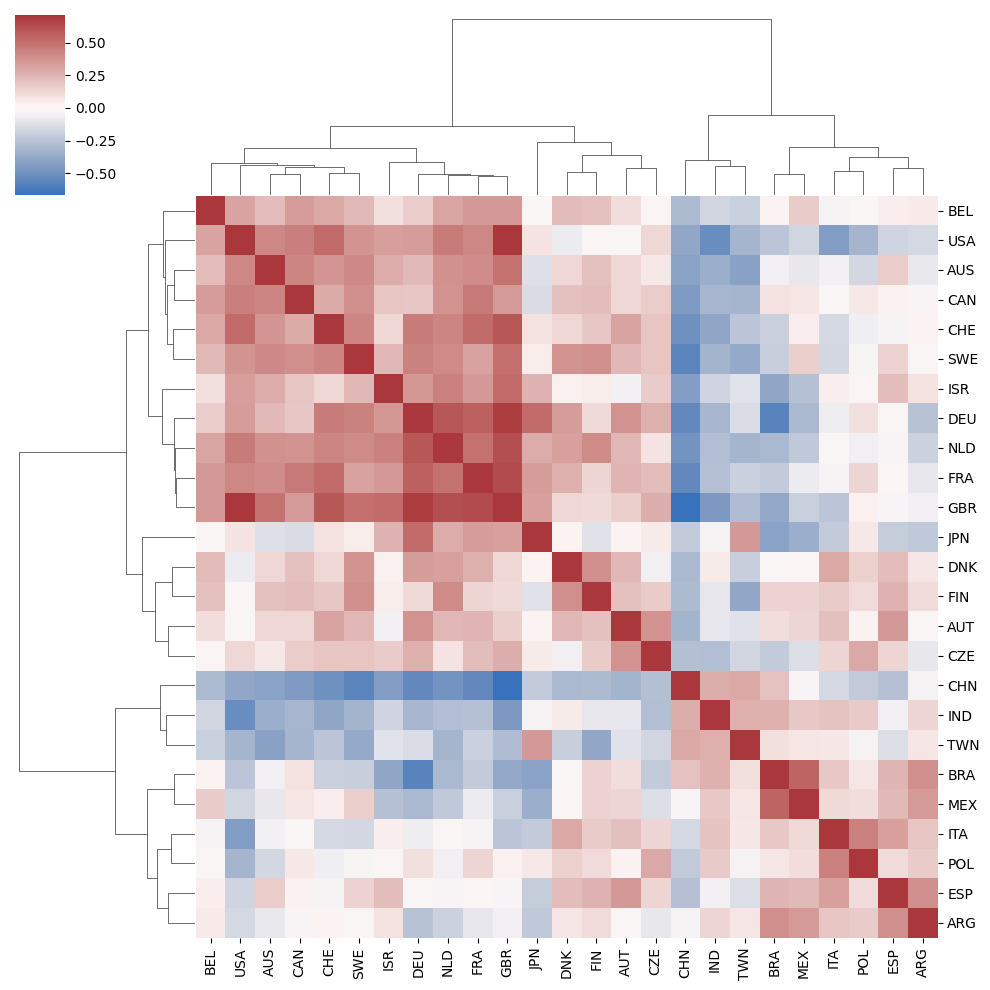

In [297]:
sns.clustermap(t25_toc_corr, method="ward", center=0, vmax=max_non_1, cmap='vlag')

file_toc_corr = work_dir / 'fig_8_2_toc_enrich_country_corr.pdf'

plt.savefig(file_toc_corr, format='pdf', bbox_inches='tight')

### Focus on top 10

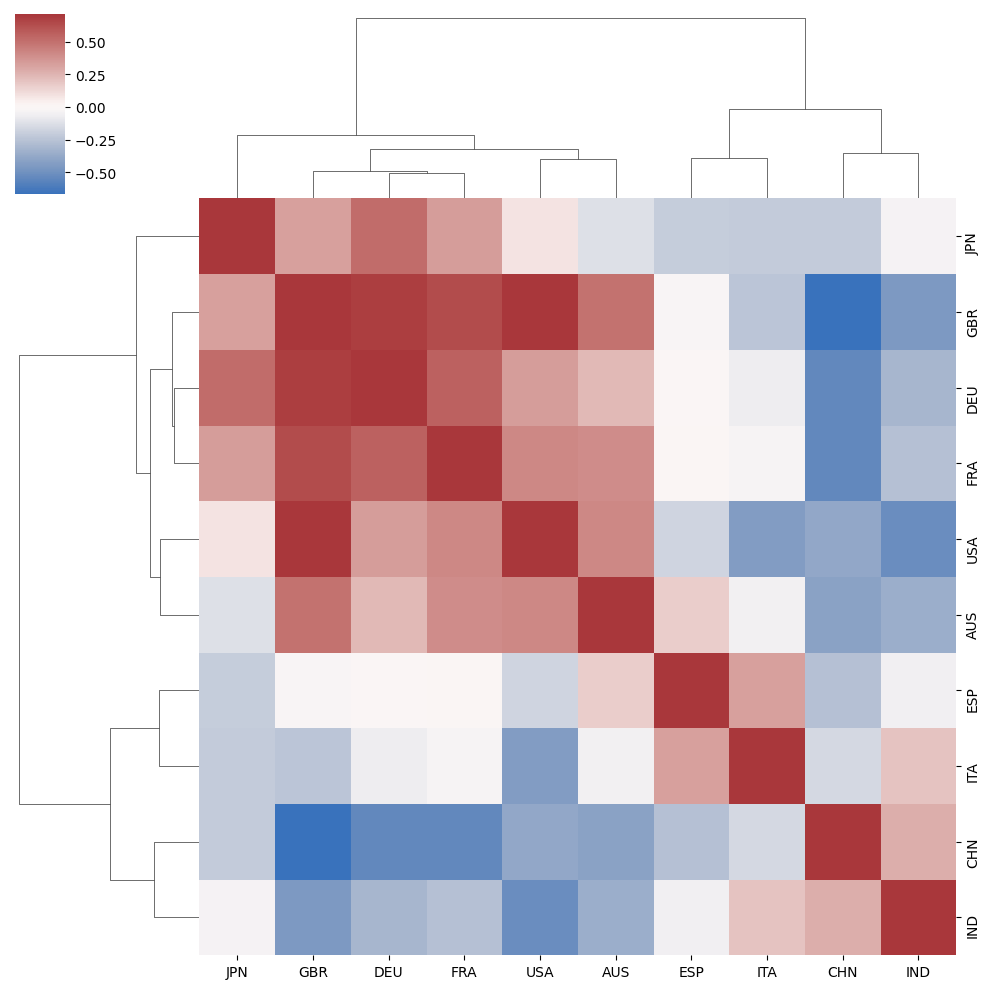

In [371]:
t10 = t25_toc_corr.iloc[:10, :10]

cm_t10 = sns.clustermap(t10, method="ward", center=0, vmax=max_non_1, cmap='vlag')
file_toc_corr10 = work_dir / 'fig_8_2_toc_enrich_country_10_corr.pdf'
cm_t10.savefig(file_toc_corr10, format='pdf', bbox_inches='tight')

### Heatmap for topic / top10 countries

Note that topic 5 is dropped.

In [315]:
t25_toc_stat = pd.read_csv(t25_toc_stat_file, index_col=0).drop([5])
t10_toc_stat = t25_toc_stat.iloc[:, 1:11]
t10_toc_stat.head(2)

,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,AUS
toc,,,,,,,,,,
0,-3.312153,-1.542355,-0.055263,1.198622,-0.706536,-1.728808,-0.129337,2.473362,1.282652,0.288292
1,-1.242767,-0.361898,0.070518,-1.373959,-0.198650,-0.394981,2.660110,-0.503193,-0.559371,-1.091094


In [316]:
t10_toc_stat.isnull().sum()

CHN    0
USA    0
JPN    0
DEU    0
FRA    0
GBR    0
IND    1
ESP    0
ITA    0
AUS    0
dtype: int64

In [317]:
t10_toc_stat['IND'] = t10_toc_stat['IND'].fillna(0)
t10_toc_stat['ESP'] = t10_toc_stat['ESP'].fillna(0)

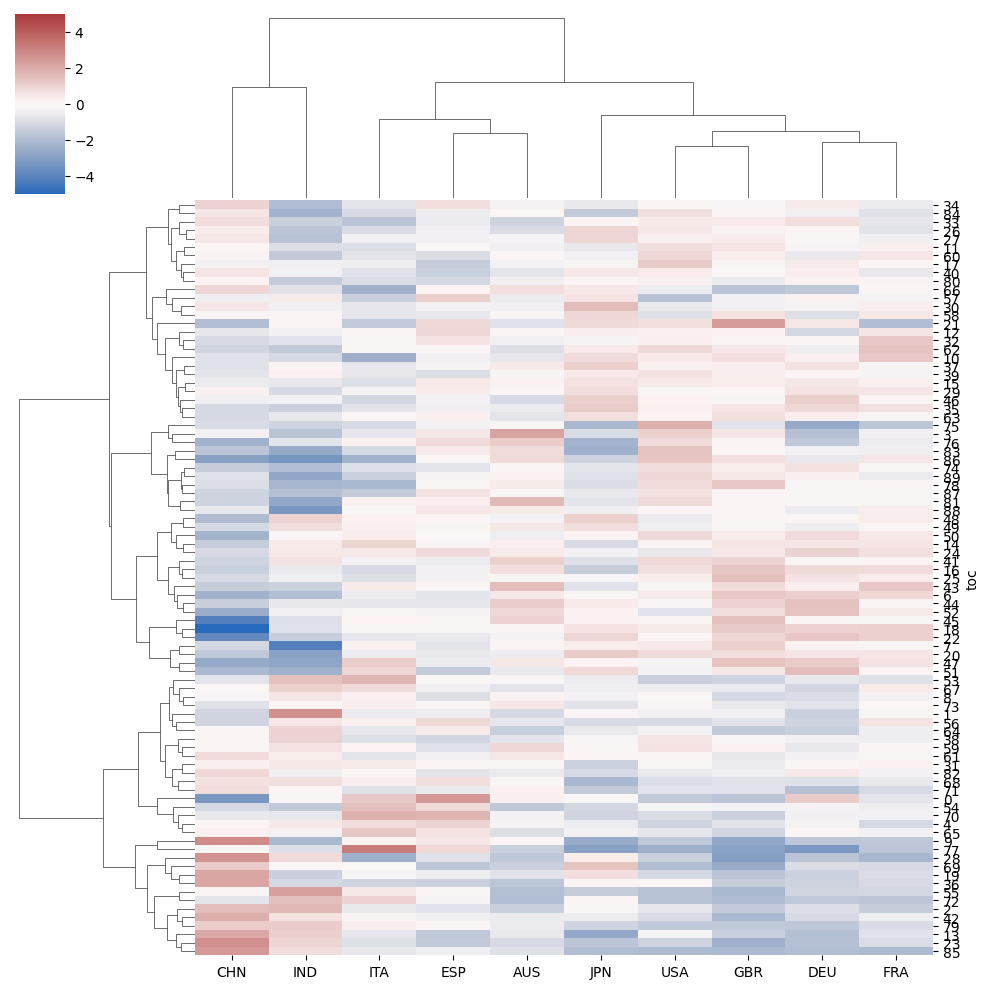

In [368]:
cm10 = sns.clustermap(t10_toc_stat, method="ward", center=0, vmin=-5, vmax=5, 
                      yticklabels=True, cmap='vlag')

plt.setp(cm10.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

file_t25_toc_stat_fig = work_dir / 'fig_8_2_t10_toc_enrichment_stat.pdf'
cm10.savefig(file_t25_toc_stat_fig, format='pdf', bbox_inches='tight')

In [340]:
cm10_yticklabels = cm10.ax_heatmap.get_yticklabels()
cm10_yticklist   = [int(l.get_text()) for l in cm10_yticklabels]
print(cm10_yticklist)

[34, 84, 33, 26, 27, 11, 60, 17, 40, 80, 66, 57, 30, 58, 21, 12, 32, 62, 10, 37, 39, 15, 29, 46, 35, 63, 75, 3, 76, 83, 86, 74, 89, 78, 87, 81, 88, 48, 49, 50, 14, 24, 41, 16, 25, 43, 6, 44, 52, 45, 18, 22, 7, 20, 47, 51, 53, 67, 8, 73, 1, 56, 64, 38, 59, 61, 31, 82, 68, 71, 0, 54, 70, 4, 65, 9, 77, 28, 69, 19, 36, 55, 72, 2, 42, 79, 13, 23, 85]


In [346]:
toc_name = t25_toc_stat['toc_name']
toc_name_sorted = [toc_name[i] for i in cm10_yticklist]
toc_name_sorted

['virulence | pathogenicity | mutants | fungal | infection',
 'soil | community | carbon | forest | fungal',
 'resistance | defense | sa | pathogen | signaling',
 'auxin | light | signaling | phytochrome | mutant',
 'development | flowering | meristem | expression | cell',
 'histone | dna methylation | chromatin | epigenetic',
 'genome | genes | sequencing | assembly',
 'database | gene | information | expression | annotation',
 'crisprcas9 | genome editing | tdna',
 'genome | chloroplast | phylogenetic | mitochondrial',
 'microsatellite markers | loci | polymorphic | alleles',
 'strain | sp nov | genus | type strain | 16s',
 'fe | cd | zn | tolerance | transporter',
 'polysaccharide | cell | wall | activity',
 'circadian clock | rhythms | flowering | arabidopsis',
 'virus | rna | protein | sequence | silencing',
 'nodules | genes | strain | mutant | virulence',
 'retrotransposons | transposable elements',
 'repair | dna | meiotic | recombination | meiosis',
 'promoter | expression | g

In [350]:
t25_toc_stat.loc[34]['toc_name'], t25_toc_stat.loc[84]['toc_name']

('virulence | pathogenicity | mutants | fungal | infection',
 'soil | community | carbon | forest | fungal')

### Get specific topic heatmap

In [379]:
# Note that toc=5 is dropped
t10_toc_stat.head(10)

,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,AUS
toc,,,,,,,,,,
0,-3.312153,-1.542355,-0.055263,1.198622,-0.706536,-1.728808,-0.129337,2.473362,1.282652,0.288292
1,-1.242767,-0.361898,0.070518,-1.373959,-0.198650,-0.394981,2.660110,-0.503193,-0.559371,-1.091094
2,1.527449,-0.670790,-0.151140,-0.898798,-1.463035,-1.492804,1.717483,-0.779417,-0.606446,-1.381859
3,-0.354139,1.074553,-1.009266,-1.862348,-0.410191,0.576386,-1.767792,0.515976,-0.702754,2.250712
4,0.023069,-1.260985,-0.544993,-0.276598,-1.110769,-0.745533,0.476713,1.020558,0.769305,-0.286351
6,-2.343031,0.394551,-0.108810,1.108182,0.878554,1.252378,-1.945473,-0.713480,-0.540380,0.476067
7,-1.168832,0.481058,0.352377,0.231454,-0.117538,1.088803,-4.149213,-0.736028,0.230377,0.180874
8,-0.165257,-0.095428,-0.340772,-0.943314,-0.383556,-1.087001,0.554900,-0.902985,0.242033,0.195952
9,2.784055,-1.576864,-2.544111,-1.608113,-1.636973,-2.693719,-2.145110,0.515906,0.170713,0.004515


In [390]:
# Only get topics mentioned in the manuscript
#https://saturncloud.io/blog/how-to-select-pandas-rows-based-on-list-index/
# The above is WRONG!!! It assumes that the index start with 0 and is continuous
# NOT TRUE in my case since topic 5 is dropped.

targets = [72, 54, 23, 28, 9, 69, 0, 86, 75, 83, 30, 51, 21, 1]

# Do this the stupid way, reduced by 1 for row index > 5
targets_mod = []
for t in targets:
  if t > 5:
    t = t-1
  targets_mod.append(t)

t10_toc14 = t10_toc_stat.iloc[targets_mod]

In [391]:
t10_toc14

,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,AUS
toc,,,,,,,,,,
72,-0.710023,-1.764232,0.038510,-1.585619,-1.677344,-2.016634,1.517113,-0.251831,1.024575,-1.932389
54,-1.058858,-0.252502,-1.161772,-0.318862,-0.498046,-0.333574,-1.560011,0.843906,1.523232,-1.607660
23,2.721902,-1.250317,-1.691558,-1.865071,-1.009674,-2.385746,0.944315,-1.528059,-0.878581,-1.023115
28,2.579070,-1.399578,0.380147,-1.724665,-2.175718,-3.040138,0.806089,-0.790527,-2.390616,-1.632330
9,2.784055,-1.576864,-2.544111,-1.608113,-1.636973,-2.693719,-2.145110,0.515906,0.170713,0.004515
69,1.188201,-1.958795,1.387936,-0.960417,-1.071221,-2.590670,0.035163,-1.653876,-0.027800,-1.363093
0,-3.312153,-1.542355,-0.055263,1.198622,-0.706536,-1.728808,-0.129337,2.473362,1.282652,0.288292
86,-2.998964,1.352035,-1.268129,-0.621579,0.525076,0.696143,-3.437025,0.031092,-2.377282,0.858410
75,-0.987823,1.881497,-2.100968,-2.638220,-1.663984,-0.765384,-1.270832,-0.343459,-1.031840,-0.089667


In [392]:
# Get the xtick list of the 10x10 heatmap of top 10 countries and sort 
# t10_toc14 based on that

# Get xtick labels
cm_t10_xlabel = cm_t10.ax_heatmap.get_xticklabels()
cm_t10_xlist  = [l.get_text() for l in cm_t10_xlabel]

# sort t10_toc14 based on xtick labels
#https://practicaldatascience.co.uk/data-science/how-to-reorder-pandas-dataframe-columns
t10_toc14 = t10_toc14[cm_t10_xlist]
t10_toc14.head(2)


,JPN,GBR,DEU,FRA,USA,AUS,ESP,ITA,CHN,IND
toc,,,,,,,,,,
72,0.038510,-2.016634,-1.585619,-1.677344,-1.764232,-1.932389,-0.251831,1.024575,-0.710023,1.517113
54,-1.161772,-0.333574,-0.318862,-0.498046,-0.252502,-1.607660,0.843906,1.523232,-1.058858,-1.560011


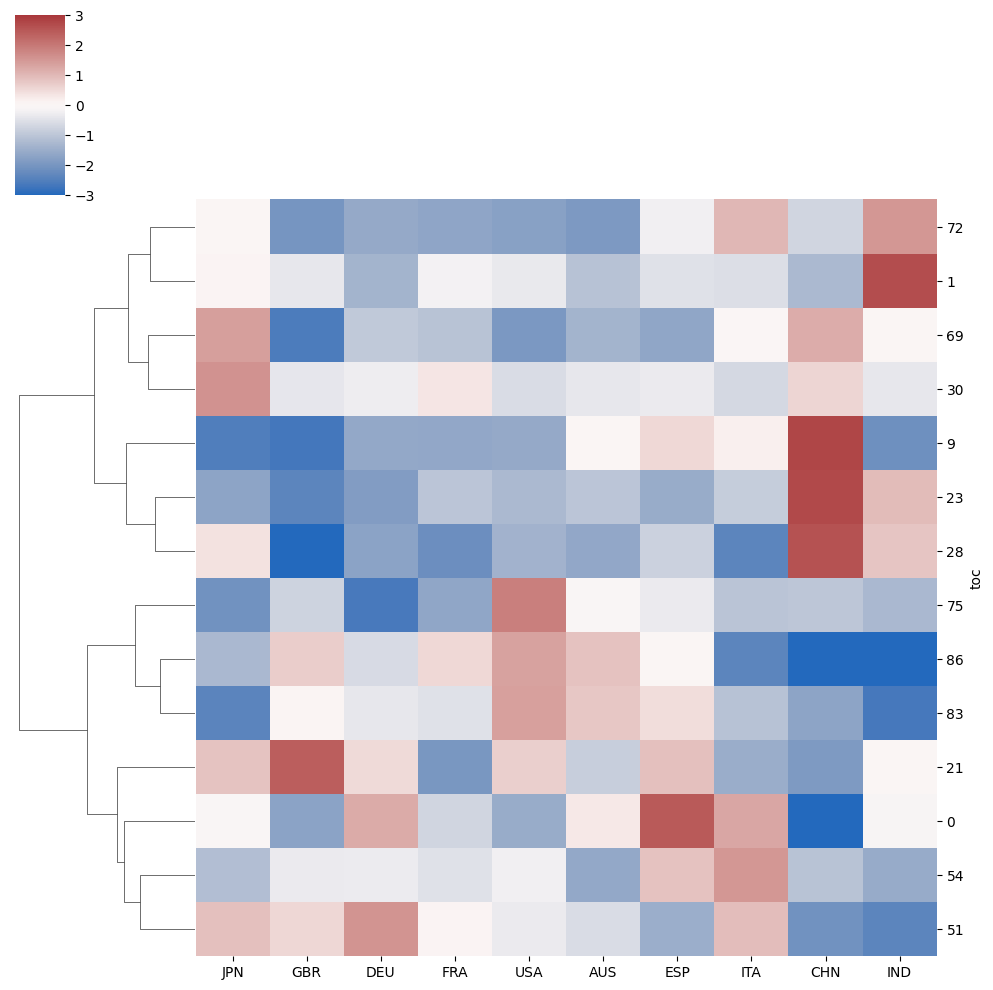

In [393]:
cm_t10_toc14 = sns.clustermap(t10_toc14, method="ward", center=0, 
                              vmin=-3, vmax=3, 
                              yticklabels=True, cmap='vlag', col_cluster=False)

plt.setp(cm_t10_toc14.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

fig_t10_toc14 = work_dir / 'fig_8_2_t10_toc14_enrichment_stat.pdf'
cm_t10_toc14.savefig(fig_t10_toc14, format='pdf', bbox_inches='tight')

In [394]:
t10_toc14_yticklabels = cm_t10_toc14.ax_heatmap.get_yticklabels()
t10_toc14_yticklist   = [int(l.get_text()) for l in t10_toc14_yticklabels]
t10_toc14_yticklist

[72, 1, 69, 30, 9, 23, 28, 75, 86, 83, 21, 0, 54, 51]

In [395]:
toc14_name_sorted = [toc_name[i] for i in t10_toc14_yticklist]
toc14_name_sorted

['extracts | activity | phenolic | antioxidant activity',
 'medium | callus | regeneration | culture | somatic',
 'compounds | new | spectroscopic | structures | nmr',
 'fe | cd | zn | tolerance | transporter',
 'reflectance | models | spectroscopy | hyperspectral | prediction',
 'gene family | gene | expression | proteins | phylogenetic',
 'stress | tolerance | transgenic | drought | aba | salt',
 'pest | aphid | larvae | resistance | host',
 'populations | genetic | selection | inbreeding | mating',
 'climate | seed | diversity | community | forest',
 'circadian clock | rhythms | flowering | arabidopsis',
 'allergen | pollen | ige | allergenic',
 'fusarium | mycotoxins | strains | aspergillus | contamination',
 'complex | photosystem ii | light | chlorophyll | lightharvesting']

## ___Test___

### NaNs between two lists

In [140]:
test1_vals = t25_toc_stat['IND'].values
test2_vals = t25_toc_stat['NLD'].values

test1_nans = np.isnan(test1_vals)
test2_nans = np.isnan(test2_vals)

#https://www.geeksforgeeks.org/how-to-invert-the-elements-of-a-boolean-array-in-python/
test1or2_nans = test1_nans | test2_nans
test1and2_nonnans = np.invert(test1or2_nans)

test1_nans, test2_nans, test1or2_nans, test1and2_nonnans

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False]),
 array([False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        Fal

In [147]:
test1_nonan = test1_vals[test1and2_nonnans]
test2_nonan = test2_vals[test1and2_nonnans]

# Expect to be 90 -1 (topic 5) - 2 (two topic with nan values) = 87
len(test1_nonan), len(test2_nonan)

(87, 87)

In [148]:
# elements are deleted properly
test1_vals[:22], test1_nonan[:22], test2_vals[:22], test2_nonan[:22]

(array([-0.12933662,  2.66010959,  1.7174831 , -1.76779159,  0.47671307,
        -1.94547324, -4.1492131 ,  0.5549004 , -2.14510986, -1.07288652,
        -0.91212946, -0.36314519,  1.06158892,  0.42454886, -0.63767684,
        -0.60575321, -0.42400763, -0.82656079, -1.36290649, -2.94103127,
                nan, -1.44313146]),
 array([-0.12933662,  2.66010959,  1.7174831 ,  0.47671307, -1.94547324,
        -4.1492131 ,  0.5549004 , -2.14510986, -1.07288652, -0.91212946,
        -0.36314519,  1.06158892,  0.42454886, -0.63767684, -0.60575321,
        -0.42400763, -0.82656079, -1.36290649, -2.94103127, -1.44313146,
         0.94431466,  0.49696444]),
 array([ 0.70030879, -0.64844307, -1.32389994,         nan, -0.68618942,
         0.35275611,  0.93099359, -0.35566446, -2.29403162, -1.03693063,
        -0.30094133,  0.82342711, -3.19207138,  1.34187893, -0.15075686,
         1.34994237,  0.08738711,  0.02734866, -0.58189349,  0.72963087,
        -1.19952463,  0.37945306]),
 array([ 0.70030

### Spectral co-clustering testing

(Text(0.5, 1.0, 'Original dataset'), (26, 26))

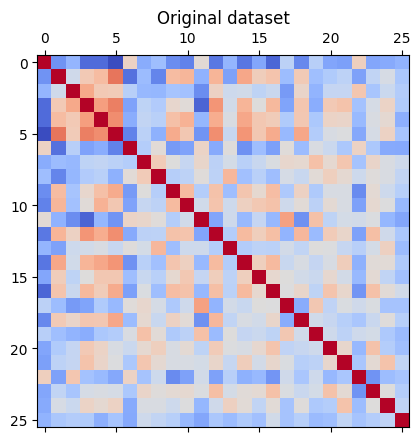

In [ ]:
# Spectral co-clustering
#https://scikit-learn.org/stable/modules/biclustering.html
#https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-coclustering-py

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score

data = np.array(t25_toc_corr)
plt.matshow(data, cmap="coolwarm")
plt.title("Original dataset"), data.shape

In [ ]:
n_clusters = 4

model = SpectralCoclustering(n_clusters=n_clusters, random_state=seed)
model.fit(data)

# row_labels_ is an array with 26 elements specifies cluster index of each row.
# np.argsort() sorted an [0,...,25] array according to row_labels_.
reordered_rows = data[np.argsort(model.row_labels_)]
reordered_data = reordered_rows[:, np.argsort(model.column_labels_)]

model.row_labels_, np.argsort(model.row_labels_)

(array([1, 2, 2, 2, 2, 2, 1, 3, 3, 0, 0, 3, 2, 0, 0, 0, 0, 3, 2, 3, 0, 0,
        1, 0, 0, 0], dtype=int32),
 array([25, 23, 21, 20, 16, 15, 14, 13,  9, 10, 24, 22,  0,  6,  5, 18,  4,
         3,  2,  1, 12,  8,  7, 17, 19, 11]))

In [ ]:
model.row_labels_.shape

(26,)

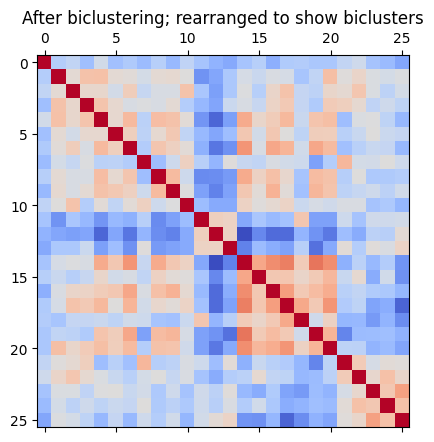

In [ ]:
plt.matshow(reordered_data, cmap="coolwarm")
plt.title("After biclustering; rearranged to show biclusters")
_ = plt.show()

### Deprecated functions

In [ ]:
# Replaced
def get_m_lst_lst_v1(a3, yr):
  '''Get a list of metric lists for a given country and year
  Args:
    a3 (str): country a3 code
    yr (int): year
  Return:
    m_lst_lst (list): [m_lst], where m_lst = [pmid, journal, issn, [Prank, SJR,
      Hidx, Cite]]
    not_found (dict): {journal: [issn, [pmids]]}
  '''
  
  df        = df_acdty.loc[(df_acdty['A3']==a3) & (df_acdty['Year']==yr)]
  pmids     = df.index
  issns     = df['ISSN'].values
  
  d_metric  = d_d_metric[yr] # {issn: [Prank, SJR, Hidx, Cite]}
  #not_found = {}             # {journal: [issn, [pmids]}
  m_lst_lst = []  # [m_lst]
  for idx, issn in enumerate(issns):
    pmid    = pmids[idx]

    # first check if issn is np.nan
    if type(issn) == float:
      if not np.isnan(issn):
        print("ERR: float but not nan", issn)
      issn = []
    else:
      issn = issn.split(",")

    # make sure issn, if exist, is in d_metric, then append to a metric list
    m_list = []
    for issn_token in issn:
      if issn_token in d_metric:
        metrics = d_metric[issn_token]
        m_list.append(metrics)

    # check if this journal is found in d_meric
    m_list2 = [] # for getting average if multiple issns
    if m_list != []:
      for idx in range(0,4):
        m_sum = 0
        for ms in m_list:
          m_sum += ms[idx]
        m_avg = m_sum / len(m_list)
        m_list2.append(m_avg)

      # need m_list2, but add more info for debugging
      m_lst_lst.append([pmid, issn,m_list2, m_list])

  return m_lst_lst

In [ ]:
# Replaced
def get_m_lst_lst_v1(a3, yr):
  '''Get a list of metric lists for a given country and year
  Args:
    a3 (str): country a3 code
    yr (int): year
  Return:
    m_lst_lst (list): [m_lst], where m_lst = [pmid, journal, issn, [Prank, SJR,
      Hidx, Cite]]
    not_found (dict): {journal: [issn, [pmids]]}
  '''
  
  df        = df_acdty.loc[(df_acdty['A3']==a3) & (df_acdty['Year']==yr)]
  pmids     = df.index
  issns     = df['ISSN'].values
  
  d_metric  = d_d_metric[yr] # {issn: [Prank, SJR, Hidx, Cite]}
  #not_found = {}             # {journal: [issn, [pmids]}
  m_lst_lst = []  # [m_lst]
  for idx, issn in enumerate(issns):
    pmid    = pmids[idx]

    # first check if issn is np.nan
    if type(issn) == float:
      if not np.isnan(issn):
        print("ERR: float but not nan", issn)
      issn = []
    else:
      issn = issn.split(",")

    # make sure issn, if exist, is in d_metric, then append to a metric list
    m_list = []
    for issn_token in issn:
      if issn_token in d_metric:
        metrics = d_metric[issn_token]
        m_list.append(metrics)

    # check if this journal is found in d_meric
    m_list2 = [] # for getting average if multiple issns
    if m_list != []:
      for idx in range(0,4):
        m_sum = 0
        for ms in m_list:
          m_sum += ms[idx]
        m_avg = m_sum / len(m_list)
        m_list2.append(m_avg)

      # need m_list2, but add more info for debugging
      m_lst_lst.append([pmid, issn,m_list2, m_list])

  return m_lst_lst

In [ ]:
# Replaced
def get_m_lst_lst_v1(a3, yr):
  '''Get a list of metric lists for a given country and year
  Args:
    a3 (str): country a3 code
    yr (int): year
  Return:
    m_lst_lst (list): [m_lst], where m_lst = [pmid, journal, issn, [Prank, SJR,
      Hidx, Cite]]
    not_found (dict): {journal: [issn, [pmids]]}
  '''
  
  df        = df_acdty.loc[(df_acdty['A3']==a3) & (df_acdty['Year']==yr)]
  pmids     = df.index
  issns     = df['ISSN'].values
  
  d_metric  = d_d_metric[yr] # {issn: [Prank, SJR, Hidx, Cite]}
  #not_found = {}             # {journal: [issn, [pmids]}
  m_lst_lst = []  # [m_lst]
  for idx, issn in enumerate(issns):
    pmid    = pmids[idx]

    # first check if issn is np.nan
    if type(issn) == float:
      if not np.isnan(issn):
        print("ERR: float but not nan", issn)
      issn = []
    else:
      issn = issn.split(",")

    # make sure issn, if exist, is in d_metric, then append to a metric list
    m_list = []
    for issn_token in issn:
      if issn_token in d_metric:
        metrics = d_metric[issn_token]
        m_list.append(metrics)

    # check if this journal is found in d_meric
    m_list2 = [] # for getting average if multiple issns
    if m_list != []:
      for idx in range(0,4):
        m_sum = 0
        for ms in m_list:
          m_sum += ms[idx]
        m_avg = m_sum / len(m_list)
        m_list2.append(m_avg)

      # need m_list2, but add more info for debugging
      m_lst_lst.append([pmid, issn,m_list2, m_list])

  return m_lst_lst